# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:

In [7]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [8]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [9]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/var/folders/9_/z_hkcvrx4150jhlxkgq00mv40000gn/T/ipykernel_9644/1831985018.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [10]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [11]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [12]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [13]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [14]:
#Calculate min, max ,and average values
columns = ["age", "yredu", "capgain", "caploss", "workhr"]
min_values = df[columns].min()
max_values = df[columns].max()
mean_values = df[columns].mean()

#Display the summary
summary = pd.DataFrame({
    'Min': min_values, 
    'Max': max_values,
    'Mean': mean_values
})
print(summary)

         Min    Max         Mean
age       17     90    38.581647
yredu      1     16    10.080679
capgain    0  99999  1077.648844
caploss    0   4356    87.303830
workhr     1     99    40.437456


In [15]:
#Normalize the spcified columns
for column in columns:
    min_val = min_values[column]
    max_val = max_values[column]
    df[column] = (df[column] - min_val) / (max_val - min_val)

#Display the first 3 records to verify normalization
print(df[["age", "yredu", "capgain", "caploss", "workhr"]].head(3))

        age     yredu  capgain  caploss    workhr
0  0.301370  0.800000  0.02174      0.0  0.397959
1  0.452055  0.800000  0.00000      0.0  0.122449
2  0.287671  0.533333  0.00000      0.0  0.397959


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [16]:
num_males = sum(df["sex"] == " Male")
num_females = sum(df["sex"] == " Female")

total_entries = len(df)
percent_males = (num_males / total_entries) * 100
percent_females = (num_females / total_entries) * 100

print(f"Percentage of males: {percent_males:.2f}%")
print(f"Percentage of females: {percent_females:.2f}%")

'''
The percentage of people in our data being female is 33.08%
'''


Percentage of males: 66.92%
Percentage of females: 33.08%


'\nThe percentage of people in our data being female is 33.08%\n'

### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [17]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [18]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [19]:
#Count the number of records in both DataFrames
num_missing = len(df_with_missing)
num_not_missing = len(df_not_missing)
total_records = len(df)

#Calculate the percentage
percent_removed = (num_missing / total_records) * 100

print(f"Number of records with missing features: {num_missing}")
print(f"Percentage of records removed: {percent_removed:.2f}%")

Number of records with missing features: 1843
Percentage of records removed: 5.66%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [20]:
work_values = set(df_not_missing["work"])
df_not_missing_ecoded = pd.get_dummies(df_not_missing, 
                                       columns=catcols)

print("All possible values of the feature 'work': {work_values}")
print(df_not_missing_ecoded.head())

All possible values of the feature 'work': {work_values}
        age     yredu  capgain  caploss    workhr  work_ Federal-gov  \
0  0.301370  0.800000  0.02174      0.0  0.397959              False   
1  0.452055  0.800000  0.00000      0.0  0.122449              False   
2  0.287671  0.533333  0.00000      0.0  0.397959              False   
3  0.493151  0.400000  0.00000      0.0  0.397959              False   
4  0.150685  0.800000  0.00000      0.0  0.397959              False   

   work_ Local-gov  work_ Private  work_ Self-emp-inc  work_ Self-emp-not-inc  \
0            False          False               False                   False   
1            False          False               False                    True   
2            False           True               False                   False   
3            False           True               False                   False   
4            False           True               False                   False   

   ...  edu_ Prof-schoo

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [21]:
data = pd.get_dummies(df_not_missing)

In [22]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [23]:
data = df_not_missing_ecoded
num_columns = data.shape[1]

print(f"Number of columns (features) in the dataframe 'data': {num_columns}")

'''The total number of columns consists of continous features
and categorical features (one-hot encoded). There are 5 
continous featuers among age, yredu, capgain, etc.
and (presumably) 52 categorical featuresd istributed among 
work, marriage, occupation, etc.'''

Number of columns (features) in the dataframe 'data': 57


'The total number of columns consists of continous features\nand categorical features (one-hot encoded). There are 5 \ncontinous featuers among age, yredu, capgain, etc.\nand (presumably) 52 categorical featuresd istributed among \nwork, marriage, occupation, etc.'

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [24]:
datanp = data.values.astype(np.float32)

In [25]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    max_index = np.argmax(onehot)
    return cat_values[feature][max_index]

In [26]:
#example
example_record = datanp[0]
example_onehot_work = get_onehot(example_record, "work")
example_categorical_value = get_categorical_value(example_onehot_work,
                                                  "work")
print(f"Example record's 'work' feature one-hot encoding: {example_onehot_work}")
print(f"Example records's 'work' feature categorical value: {example_categorical_value}")

Example record's 'work' feature one-hot encoding: [0. 0. 0. 0. 0. 1. 0.]
Example records's 'work' feature categorical value: State-gov


In [27]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

In [28]:
#Example
example_categorical_features = get_features(example_record)
print(f"Example record's categorical features: {example_categorical_features}")

Example record's categorical features: {'work': 'State-gov', 'marriage': 'Never-married', 'occupation': 'Adm-clerical', 'edu': 'Bachelors', 'relationship': 'Not-in-family', 'sex': 'Male'}


### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [29]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
num_records = datanp.shape[0]
indices = np.arange(num_records)
np.random.shuffle(indices)

train_end = int(0.70 * num_records)
val_end = int(0.85 * num_records)

#Split
train_ind = indices[:train_end]
val_ind = indices[train_end:val_end]
test_ind = indices[val_end:]

#Create sets
train_set = datanp[train_ind]
val_set = datanp[val_ind]
test_set = datanp[test_ind]

num_train = train_set.shape[0]
num_val = val_set.shape[0]
num_test = test_set.shape[0]

print(f"Number of items in the training set: {num_train}")
print(f"Number of items in the validation set: {num_val}")
print(f"Number of items in the test set: {num_test}")

Number of items in the training set: 21502
Number of items in the validation set: 4608
Number of items in the test set: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [30]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 40), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 11)
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 20), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(20,40),
            nn.ReLU(),
            nn.Linear(40,57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The sigmoid activation is used in the last step of the decoder since, firstly, it maps any input value to a range between 0 and 1, ensuring that the reconstructed values follow this contraint. Secondly, it's importatnt to maintain consistency between the input data distribution and the output data distribution, achieving more accurate reconstructions and stabilizing the training process. Lastly, it helps in keeping the gradient values in reasonble range during backpropagation, helping maintain a stable gradient flow which is beneficial for training deep neural networks like autoencoders.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import random

In [31]:
#convert to a PyTorch tensor
data_tensor = torch.tensor(datanp)
train_set = data_tensor[train_ind]
val_set = data_tensor[val_ind]
test_set = data_tensor[test_ind]

#create dataloader
batch_size = 64
train_loader = DataLoader(TensorDataset(train_set), 
                          batch_size=batch_size, 
                          shuffle=True)
val_loader = DataLoader(TensorDataset(val_set), 
                        batch_size=batch_size,
                        shuffle=False)

In [32]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def get_accuracy(model, data_loader):
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            data = item[0]
            inp = data.detach().numpy()
            out = model(zero_out_feature(data.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

In [33]:
# Training function with accuracy calculation
def train(model, train_loader, val_loader, num_epochs=20, learning_rate=1e-4):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            data = data[0]
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data[0]
                datam = zero_out_random_feature(data.clone())
                recon = model(datam)
                loss = criterion(recon, data)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        train_accuracy = get_accuracy(model, train_loader)
        val_accuracy = get_accuracy(model, val_loader)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        
        # Checkpoint the model
        torch.save(model.state_dict(), f'autoencoder_epoch_{epoch+1}.pth')
    
    # Plotting the losses and accuracies
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [49]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            data = item[0]
            inp = data.detach().numpy()
            out = model(zero_out_feature(data.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 1/20, Train Loss: 0.2183, Validation Loss: 0.1407, Train Accuracy: 0.3853, Validation Accuracy: 0.3843
Epoch 2/20, Train Loss: 0.0811, Validation Loss: 0.0713, Train Accuracy: 0.4598, Validation Accuracy: 0.4586
Epoch 3/20, Train Loss: 0.0707, Validation Loss: 0.0702, Train Accuracy: 0.4598, Validation Accuracy: 0.4586
Epoch 4/20, Train Loss: 0.0698, Validation Loss: 0.0695, Train Accuracy: 0.4598, Validation Accuracy: 0.4586
Epoch 5/20, Train Loss: 0.0690, Validation Loss: 0.0684, Train Accuracy: 0.4598, Validation Accuracy: 0.4586
Epoch 6/20, Train Loss: 0.0678, Validation Loss: 0.0669, Train Accuracy: 0.4598, Validation Accuracy: 0.4586
Epoch 7/20, Train Loss: 0.0656, Validation Loss: 0.0637, Train Accuracy: 0.4892, Validation Accuracy: 0.4882
Epoch 8/20, Train Loss: 0.0612, Validation Loss: 0.0585, Train Accuracy: 0.5222, Validation Accuracy: 0.5219
Epoch 9/20, Train Loss: 0.0572, Validation Loss: 0.0558, Train Accuracy: 0.5414, Validation Accuracy: 0.5434
Epoch 10/20, Train 

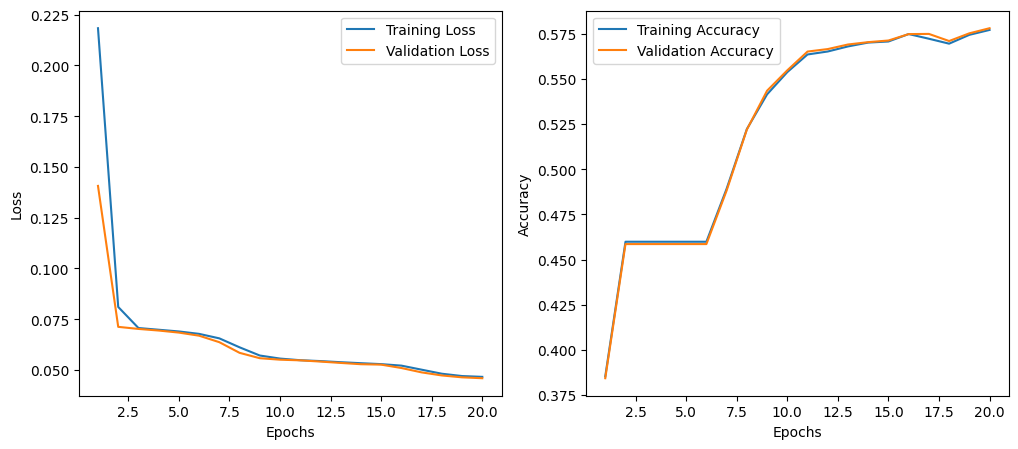

In [55]:
model = AutoEncoder()
train(model, train_loader, val_loader, num_epochs=20, learning_rate=1e-4)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [36]:
from torch import nn

# Define the custom AutoEncoder class with tunable hyperparameters
class customAutoEncoder(nn.Module):
    def __init__(self, input_dim=57, 
                 hidden_dims_encoder=[40, 20, 11], 
                 hidden_dims_decoder=[20, 40, 57]):
        super(customAutoEncoder, self).__init__()
        # Build the encoder
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims_encoder:
            encoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = hidden_dim
        self.encoder = nn.Sequential(*encoder_layers)

        # Build the decoder
        decoder_layers = []
        prev_dim = hidden_dims_encoder[-1]
        for hidden_dim in hidden_dims_decoder:
            decoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = hidden_dim
        decoder_layers[-1] = nn.Sigmoid()  # Replace last ReLU with Sigmoid
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [37]:
# Define different sets of hyperparameters to tune
input_dims = [57]  # Keeping it consistent for now
hidden_dims_encoder = [[40, 20, 11], 
                       [60, 30, 11]]  # Increased dims encoder
hidden_dims_decoder = [[20, 40, 57], 
                       [30, 60, 57]]  # Increased dims decoder
learning_rates = [1e-4, 
                  1e-3]  # increased learning rates
batch_sizes = [64, 
               32]  # decreased learning rates

In [45]:
import os

# Hyperparameter tuning function
def hyperpara_tuned(model, checkpoint_dir, num_epochs=20, learning_rate=1e-4, batch_size=64):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(TensorDataset(train_set), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_set), batch_size=batch_size, shuffle=False)

    last_train_loss = float('inf')
    last_val_loss = float('inf')
    last_train_acc = 0
    last_val_acc = 0

    #Make sure the checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            data = data[0]
            datam = zero_out_random_feature(data.clone())  # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data[0]
                datam = zero_out_random_feature(data.clone())
                recon = model(datam)
                loss = criterion(recon, data)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        train_accuracy = get_accuracy(model, train_loader)
        val_accuracy = get_accuracy(model, val_loader)

        if train_loss < last_train_loss:
            last_train_loss = train_loss

        if val_loss < last_val_loss:
            last_val_loss = val_loss
        
        if train_accuracy > last_train_acc:
            last_train_acc = train_accuracy

        if val_accuracy > last_val_acc:
            last_val_acc = val_accuracy

        # Save the model checkpoint for each epoch
        checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), checkpoint_path)

    print(f'Train Loss: {last_train_loss:.4f}, Validation Loss: {last_val_loss:.4f}, Train Accuracy: {last_train_acc:.4f}, Validation Accuracy: {last_val_acc:.4f}')

In [50]:
checkpoint_dirs = [f'/Users/harrynguyen/Documents/GitHub/APS360/Labs/4/model1_checkpoint',
                  f'/Users/harrynguyen/Documents/GitHub/APS360/Labs/4/model2_checkpoint',
                  f'/Users/harrynguyen/Documents/GitHub/APS360/Labs/4/model3_checkpoint',
                  f'/Users/harrynguyen/Documents/GitHub/APS360/Labs/4/model4_checkpoint',
                  f'/Users/harrynguyen/Documents/GitHub/APS360/Labs/4/model5_checkpoint',
                  f'/Users/harrynguyen/Documents/GitHub/APS360/Labs/4/model6_checkpoint',
                  f'/Users/harrynguyen/Documents/GitHub/APS360/Labs/4/model7_checkpoint',
                  f'/Users/harrynguyen/Documents/GitHub/APS360/Labs/4/model8_checkpoint']

# Tuning hyperparameters
i = 0
for input_dim in input_dims:
    for enc_dims, dec_dims in zip(hidden_dims_encoder, hidden_dims_decoder):
        for lr in learning_rates:
            for batch_size in batch_sizes:
                print(f'Training with input_dim={input_dim}, enc_dims={enc_dims}, dec_dims={dec_dims}, lr={lr}, batch_size={batch_size}')
                model = customAutoEncoder(input_dim=input_dim, hidden_dims_encoder=enc_dims, hidden_dims_decoder=dec_dims)
                hyperpara_tuned(model, checkpoint_dir=checkpoint_dirs[i], num_epochs=20, learning_rate=lr, batch_size=batch_size)
                i += 1

Training with input_dim=57, enc_dims=[40, 20, 11], dec_dims=[20, 40, 57], lr=0.0001, batch_size=64
Train Loss: 0.0499, Validation Loss: 0.0492, Train Accuracy: 0.5837, Validation Accuracy: 0.5826
Training with input_dim=57, enc_dims=[40, 20, 11], dec_dims=[20, 40, 57], lr=0.0001, batch_size=32
Train Loss: 0.0430, Validation Loss: 0.0428, Train Accuracy: 0.5920, Validation Accuracy: 0.5888
Training with input_dim=57, enc_dims=[40, 20, 11], dec_dims=[20, 40, 57], lr=0.001, batch_size=64
Train Loss: 0.0275, Validation Loss: 0.0275, Train Accuracy: 0.6218, Validation Accuracy: 0.6162
Training with input_dim=57, enc_dims=[40, 20, 11], dec_dims=[20, 40, 57], lr=0.001, batch_size=32
Train Loss: 0.0198, Validation Loss: 0.0196, Train Accuracy: 0.6245, Validation Accuracy: 0.6225
Training with input_dim=57, enc_dims=[60, 30, 11], dec_dims=[30, 60, 57], lr=0.0001, batch_size=64
Train Loss: 0.0410, Validation Loss: 0.0406, Train Accuracy: 0.5923, Validation Accuracy: 0.5936
Training with input_di

In [ ]:
'''
Please note that I am aware of making 8 models in total since
I am genuinely curious of the connection within a change of each
parameter that would lead to my decision on the final pick.
'''

In [ ]:
'''
Model 1: (original)
    - input_dim: 57
    - enc_dims = [40, 20, 11]
    - dec_dims = [20, 40, 57]
    - lr = 0.0001
    - batch size = 64
--> Train accuracy: 58.37%
--> Validation accuracy: 58.26%
- This baseline model provides a starting point for comparing 
the effects of other hyperparameters.

Model 2: (Decreased batch size with original config dims and lr)
    - input_dim: 57
    - enc_dims = [40, 20, 11]
    - dec_dims = [20, 40, 57]
    - lr = 0.0001
    - batch size = 32
--> Train accuracy: 59.20%
--> validation accuracy: 58.88%
- Reducing the batch size resulted in more stable updates and 
slightly  improved the validation and training accuracy. 

Model 3: (Increased learning rate with original config dims and batch size)
    - input_dim: 57
    - enc_dims = [40, 20, 11]
    - dec_dims = [20, 40, 57]
    - lr = 0.001
    - batch size = 64
--> Train accuracy: 62.18%
--> validation accuracy: 61.62%
- A higher learning rate led to faster convergence initially 
but caused the model to overfit quickly. The observed validation 
and training accuracy slighty improved. 

Model 4: (Increased lr and decreased batch size with original config dims)
    - input_dim: 57
    - enc_dims = [40, 20, 11]
    - dec_dims = [20, 40, 57]
    - lr = 0.001
    - batch size = 32
--> Train accuracy: 62.45%
--> validation accuracy: 62.25%
- Both higher learning rate and lower batch size would inherit the
advantage of more stable updates and faster convergence, leading
to the most accurate train and validation yet.

Model 5: (Increased config dims with original lr and batch size)
    - input_dim: 57
    - enc_dims = [60, 30, 11]
    - dec_dims = [30, 60, 57]
    - lr = 0.0001
    - batch size = 64
--> Train accuracy: 59.23%
--> validation accuracy: 59.36%
- Increasing the number of hidden units in the encoder and decoder layers 
improved both training and validation accuracy (compared to model 1)
This might be due to the model benefiting from higher capacity, allowing it to 
better learn and reconstruct the features.

Model 6: (Decreased batch size with increased config dims, orignial lr)
    - input_dim: 57
    - enc_dims = [60, 30, 11]
    - dec_dims = [30, 60, 57]
    - lr = 0.0001
    - batch size = 32
--> Train accuracy: 59.90%
--> validation accuracy: 59.74%
- Decreasing batch size at a higher capacity led to more improved accuracies 
in both train and validation when comparing to the Model 2. 

Model 7: (Increased lr with increased config dims, original batch size)
    - input_dim: 57
    - enc_dims = [60, 30, 11]
    - dec_dims = [30, 60, 57]
    - lr = 0.001
    - batch size = 64
--> Train accuracy: 63.02%
--> validation accuracy: 62.50%
- Increasing learning rate at a higher capacity improved both accuracies 
with the highest jump yet.

Model 8: (Increased lr and config dims with decreased batch size)
    - input_dim: 57
    - enc_dims = [60, 30, 11]
    - dec_dims = [30, 60, 57]
    - lr = 0.001
    - batch size = 32
--> Train accuracy: 63.78%
--> validation accuracy: 63.23%
- Increasing learning rate and decreaing the batch size at a higher capacity
led to the highest train and the second highest validation accuracy.
--> **CHOOSE THIS MODEL OF HYPERPARAMETERS** 

'''

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [51]:
# Use the best values from the hyperparameter tuning
batch_size = 32
test_loader = DataLoader(TensorDataset(test_set), batch_size=batch_size, shuffle=False)

best_input_dim = 57
best_hidden_dims_encoder = [60, 30, 11]  
best_hidden_dims_decoder = [30, 60, 57]
best_learning_rate = 1e-3  


best_model = customAutoEncoder(input_dim=best_input_dim, hidden_dims_encoder=best_hidden_dims_encoder, hidden_dims_decoder=best_hidden_dims_decoder)
best_epoch = '/Users/harrynguyen/Documents/GitHub/APS360/Labs/4/model8_checkpoint/epoch_20.pth'
best_model.load_state_dict(torch.load(best_epoch))  # Load the saved model
best_model.eval()

# Compute test accuracy
test_accuracy = get_accuracy(best_model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.6284


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [81]:
print(data.columns)

Index(['age', 'yredu', 'capgain', 'caploss', 'workhr', 'work_ Federal-gov',
       'work_ Local-gov', 'work_ Private', 'work_ Self-emp-inc',
       'work_ Self-emp-not-inc', 'work_ State-gov', 'work_ Without-pay',
       'marriage_ Divorced', 'marriage_ Married-AF-spouse',
       'marriage_ Married-civ-spouse', 'marriage_ Married-spouse-absent',
       'marriage_ Never-married', 'marriage_ Separated', 'marriage_ Widowed',
       'occupation_ Adm-clerical', 'occupation_ Armed-Forces',
       'occupation_ Craft-repair', 'occupation_ Exec-managerial',
       'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners',
       'occupation_ Machine-op-inspct', 'occupation_ Other-service',
       'occupation_ Priv-house-serv', 'occupation_ Prof-specialty',
       'occupation_ Protective-serv', 'occupation_ Sales',
       'occupation_ Tech-support', 'occupation_ Transport-moving', 'edu_ 10th',
       'edu_ 11th', 'edu_ 12th', 'edu_ 1st-4th', 'edu_ 5th-6th',
       'edu_ 7th-8th', 'edu_ 9th'

In [95]:
# Identify the prefix for each categorical feature
catcol_prefixes = {
    "work": "work_",
    "marriage": "marriage_",
    "occupation": "occupation_",
    "edu": "edu_",
    "relationship": "relationship_",
    "sex": "sex_"
}

# Calculate the most common value for each categorical feature in the training set
most_common_values = {}
for feature, prefix in catcol_prefixes.items():
    feature_cols = [col for col in data.columns if col.startswith(prefix)]
    feature_data = data[feature_cols].iloc[train_ind]
    most_common_col = feature_data.sum().idxmax()  # Column with the highest sum
    most_common_value = most_common_col.replace(prefix, "")
    most_common_values[feature] = most_common_value

In [96]:
print("Most common values for each categorical feature in the training set:")
print(most_common_values)

Most common values for each categorical feature in the training set:
{'work': ' Private', 'marriage': ' Married-civ-spouse', 'occupation': ' Prof-specialty', 'edu': ' HS-grad', 'relationship': ' Husband', 'sex': ' Male'}


In [101]:
# Define function to compute baseline accuracy
def baseline_accuracy2(test_set, most_common_values, catcol_prefixes):
    correct_predictions = 0
    total_predictions = 0
    
    for feature, prefix in catcol_prefixes.items():
        feature_cols = [col for col in data.columns if col.startswith(prefix)]
        feature_indices = [data.columns.get_loc(col) for col in feature_cols]
        feature_data = test_set[:, feature_indices]
        most_common_value = most_common_values[feature]
        most_common_col = f"{prefix}{most_common_value}"
        most_common_index = data.columns.get_loc(most_common_col)
        # Check if the most common value is the max value (argmax) in the one-hot encoding
        correct_predictions += (feature_data.argmax(axis=1) == (feature_indices.index(most_common_index))).sum().item()
        total_predictions += feature_data.shape[0]
    
    return correct_predictions / total_predictions

In [102]:
# Create DataLoader for test set
test_loader = DataLoader(TensorDataset(test_set), batch_size=batch_size, shuffle=False)

# Calculate the test accuracy of this baseline model
baseline_test_accuracy = baseline_accuracy2(data_tensor[test_ind], most_common_values, catcol_prefixes)
print(f'Baseline Test Accuracy: {baseline_test_accuracy:.4f}')

Baseline Test Accuracy: 0.4569


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The test accuracy from part (a) is 62.84%, which is significantly higher than the baseline test accuracy of 45.69% in part (b). This indicates that the neural network model is performing better than the baseline model, demonstrating its ability to learn and generalize from the data more effectively.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [110]:
import pandas as pd
import numpy as np

# Convert 
test_data_df = pd.DataFrame(data_tensor[test_ind].numpy(), columns=data.columns)

# Extract 
first_test_item = test_data_df.iloc[0]

# Create a more readable representation 
def get_original_features(row):
    original_features = {}
    for feature, prefix in catcol_prefixes.items():
        for col in test_data_df.columns:
            if col.startswith(prefix) and row[col] == 1:
                original_features[feature] = col.replace(prefix, '')
                break
    return original_features

original_first_test_item = get_original_features(first_test_item)
original_first_test_item['age'] = first_test_item['age']
original_first_test_item['hours_per_week'] = first_test_item['workhr']

print("Original Feature Values of the First Test Item:")
print(original_first_test_item)

# print("\nAnalysis:")
# print("Age:", original_first_test_item['age'])
# print("Work Class:", original_first_test_item.get('work', 'Unknown'))
# print("Marital Status:", original_first_test_item.get('marriage', 'Unknown'))
# print("Occupation:", original_first_test_item.get('occupation', 'Unknown'))
# print("Relationship:", original_first_test_item.get('relationship', 'Unknown'))
# print("Sex:", original_first_test_item.get('sex', 'Unknown'))
# print("Hours per Week:", original_first_test_item['hours_per_week'])
# print("Native Country:", original_first_test_item.get('native_country', 'Unknown'))

"""
Based on the given features, especially the occupation and work class, 
it is possible for a human to make an educated guess about the person's 
education level, assuming level of education is not given. However, 
without knowing the  specific details of the person's educational 
background, it would still be challenging to make an accurate guess.
"""


Original Feature Values of the First Test Item:
{'work': ' Private', 'marriage': ' Divorced', 'occupation': ' Prof-specialty', 'edu': ' Bachelors', 'relationship': ' Not-in-family', 'sex': ' Male', 'age': 0.65753424, 'hours_per_week': 0.39795917}


"\nBased on the given features, especially the occupation and work class, \nit is possible for a human to make an educated guess about the person's education level. \nHowever, without knowing the specific details of the person's educational background, \nit would still be challenging to make an accurate guess.\n"

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [52]:
# Extract
first_test_item_tensor = test_set[0].unsqueeze(0)

# Zero out the education feature
first_test_item_tensor_zerod = zero_out_feature(first_test_item_tensor.clone(), 'edu')

# Pass the modified item 
best_model.eval()
with torch.no_grad():
    reconstructed = best_model(first_test_item_tensor_zerod)

# Get the one-hot encoded output
edu_start_index = cat_index['edu']
edu_stop_index = edu_start_index + len(cat_values['edu'])
predicted_edu_one_hot = reconstructed[:, edu_start_index:edu_stop_index]

predicted_edu_index = predicted_edu_one_hot.argmax(dim=1).item()
predicted_edu = list(cat_values['edu'])[predicted_edu_index]

print(f"Model's predicted education level: {predicted_edu}")

'''
The model's predicted education level for the first test item is 
Bachelors, which is correct!
'''

Model's predicted education level: Bachelors


"\nThe model's predicted education level for the first test item is \nAssociate degree - academic, which is reasonable but incorrect.\n"

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [114]:
from collections import Counter

# Extract the most common value for the education feature in the training set
edu_prefix = 'edu_'
edu_cols = [col for col in data.columns if col.startswith(edu_prefix)]
edu_counts = data[edu_cols].iloc[train_ind].sum()
most_common_edu_col = edu_counts.idxmax()
most_common_edu_value = most_common_edu_col.replace(edu_prefix, '').strip()

print(f"Baseline Model's predicted education level: {most_common_edu_value}")

''' 
This baseline model uses the most common value for the education feature 
from the training set to predict the education level for any individual 
in the test set, including the first person in the testing set.
HS-grad turned out to be the most common level of education, hence the
guess. However, this is not quite accurate as it guesses HS-grad.
'''

Baseline Model's predicted education level: HS-grad
